# Работа с данными на python

# Домашнее задание №1. Выявление корреляций со смертностью среди пассажиров Титаника и проверка гипотез.

## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Загрузка данных

In [2]:
titanic_df = pd.read_csv('https://github.com/PonchaCape/sberbank_data_analysis/raw/master/data/titanic/train.csv')

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.shape

(891, 12)

Данные подгружены корректно, посмотрим на их описание, взятое из интернета.

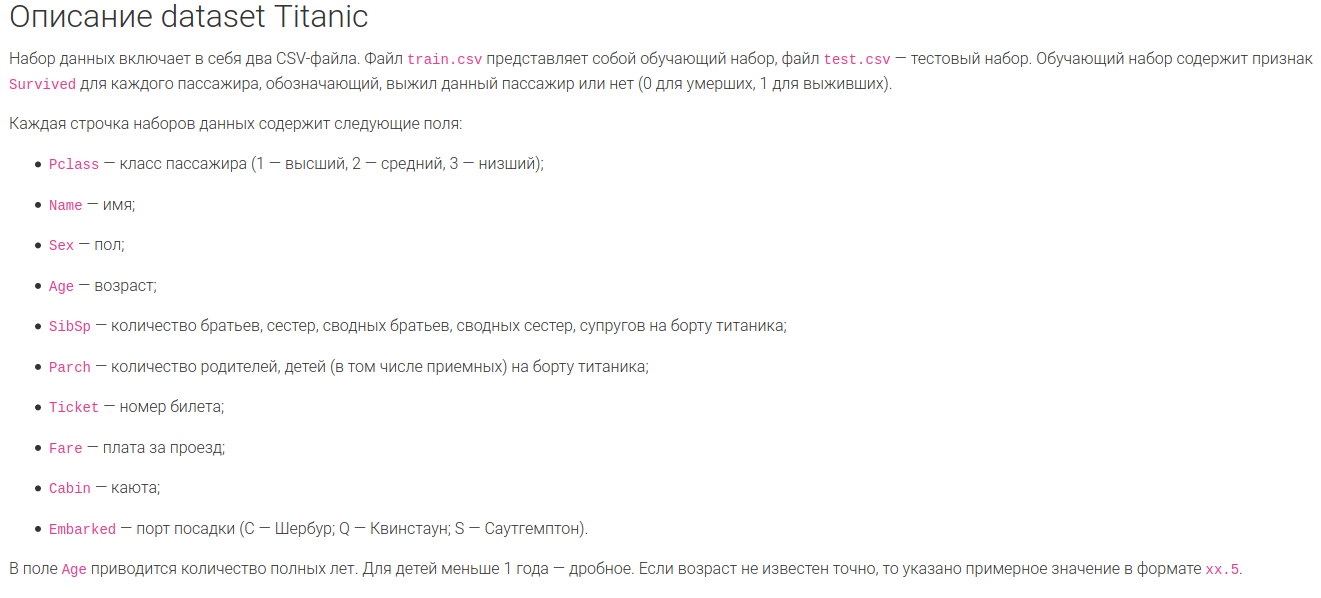

## Исследование данных

Прежде чем предложить какие-либо гипотезы, я посмотрю простую описательную статистику по датасету, чтобы получить представление об имеющихся данных. Начну с проверки типов данных.

In [5]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Итак, мы имеем:
1. Два столбца с числовыми данными типа float64.
2. Пять столбцов с данными типа int64, два из которых очевидно категориальные. PassengerID скорее всего обладает уникальными значениями.
3. Ещё пять столбцов с типом object, как минимум два из которых тоже выдают категориальные значения.

In [6]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


По средней в столбце Survived видно, что выживших около 38%.

В столбце Pclass медиана принимает значение 3, значит что более половины пассажиров путешествуют третьим классом.

Столбец Age говорит нам о том, что большая часть пассажиров молодые - среднее арифметическое и медиана ниже 30. Только лишь последний квартиль включает в себя людей старше 38 с разбросом до максимального значения 80.

В SibSP (siblings and spouses) более половины пассажиров имеют значение 0.
Parch (parents and children) более 75% имеют значение 0.

Стоимость билета имеет довольно большой разброс. И похоже, что даже в пределах одного класса также есть разброс.

In [7]:
titanic_df.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hansen, Mr. Henrik Juul",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


Столцы Embarked и Sex имеют малое количество уникальных значений, что вкупе с описанием даёт основание считать их категориальными. Пожалуй, стоит перевести их в числовой вид.

Столбец с именами содержит уникальные значения и непонятно, даст ли нам какую-то полезную информацию.

Cabin(каюта) имеет большое количество пропусков. Можно проверить, имеется ли корреляция между наличием информации о каюте и выживаемости пассажира.

## Очистка данных

Для начала столбец PassengerID установлю в качестве индекса, а пол пассажиров переведу в числовой вид.

In [8]:
titanic_df.set_index('PassengerId', inplace = True)

In [9]:
titanic_df.Sex.replace({'male': 1, 'female': 0}, inplace = True)

## Построение графиков и проверка гипотез

Нужно исследовать карту корреляций и проверить, какие из значений напрямую коррелируют со смертностью

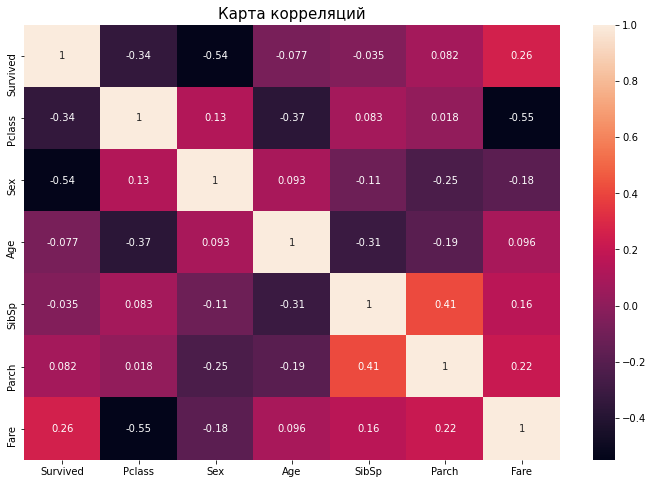

In [10]:
plt.figure(figsize = (12,8))
plt.title('Карта корреляций', size = 15)
sns.heatmap(titanic_df.corr(), annot = True)
plt.show()

Видно, что с целевой переменной Survived наибольший коэффициент линейной корреляции показал пол пассажира, затем его класс, и стоимость за билет.

Интересно, что стоимость билета с классом пассажира коррелирует не так сильно, как можно было бы подумать. А ещё между классом и возрастом пассажира прослеживается связь, но между возрастом и выживаемостью она не так сильна.

### "Спасайте женщин и детей!"
### Гипотеза №1 - женщин и детей старались спасти в первую очередь и смертность среди них была ниже.

In [11]:
sex_survived_crosstab = pd.crosstab(titanic_df.Sex, titanic_df.Survived, 
                                    margins = True, margins_name = 'Total')
sex_survived_crosstab

Survived,0,1,Total
Sex,,,
0,81,233,314
1,468,109,577
Total,549,342,891


Здесь видно, что в целом мужчин больше женщин практически в 2 раза, но выживаемость среди них при этом значительно меньше. На каждую погибшую женщину приходится практически 6 погибших мужчин.

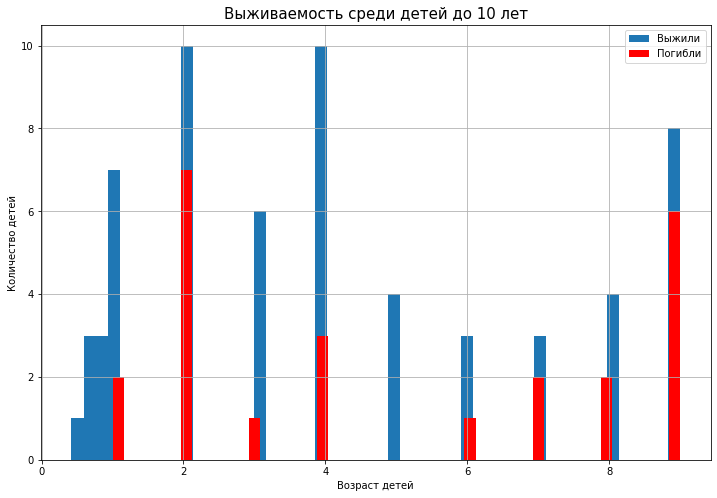

In [12]:
titanic_df['Age'][titanic_df['Age'] < 10].hist(bins = 50, figsize = (12,8))
titanic_df.Age[(titanic_df.Age < 10) & (titanic_df.Survived == 0)].hist(bins = 50, figsize = (12,8), color = 'red')
plt.title('Выживаемость среди детей до 10 лет', size = 15)
plt.legend(['Выжили', 'Погибли'])
plt.xlabel('Возраст детей')
plt.ylabel('Количество детей')
plt.show()

Среди детей до двух лет из 14 только 2 погибли - это большая доля выживших.

Также относительно большой процент выживаемости среди детей возрастом от 3 до 5 лет. Далее эта закономерность так сильно не прослеживается.

Почему-то большой процент смертности среди детей двух лет. Может ли это быть связано с классом? Это наталкивает на вторую гипотезу.

### "Кошелёк или жизнь!"
### Гипотеза №2 - пассажиры с классом выше третьего выживали гораздо чаще.

In [13]:
titanic_df[['Pclass', 'Fare', 'Survived']][titanic_df.Age == 2]

,Pclass,Fare,Survived
PassengerId,,,
8,3,21.0750,0
17,3,29.1250,0
120,3,31.2750,0
206,3,10.4625,0
298,1,151.5500,0
341,2,26.0000,1
480,3,12.2875,1
531,2,26.0000,1
643,3,27.9000,0


Среди погибших все в третьем классе (низшем), за исключением 1 ребёнка первого класса. Сгруппирую подобную статистику по возрасту у других детей до пяти лет включительно.

In [14]:
titanic_df[['Age', 'Pclass', 'Survived', 'Name']][titanic_df.Age < 6].groupby(['Age', 'Survived', 'Pclass']).count()

Name
Age  Survived Pclass      
0.42 1        3          1
0.67 1        2          1
0.75 1        3          2
0.83 1        2          2
0.92 1        1          1
1.00 0        3          2
     1        2          2
              3          3
2.00 0        1          1
              3          6
     1        2          2
              3          1
3.00 0        3          1
     1        2          3
              3          2
4.00 0        3          3
     1        1          1
              2          2
              3          4
5.00 1        2          1
              3          3

Итак, среди 13 погибших детей до пяти лет включительно погиб только 1 ребёнок, не принадлежащий третьему классу. Это довольно сильный аргумент в пользу гипотезы. Посмотрим на подобную статистику среди всех пассажиров.

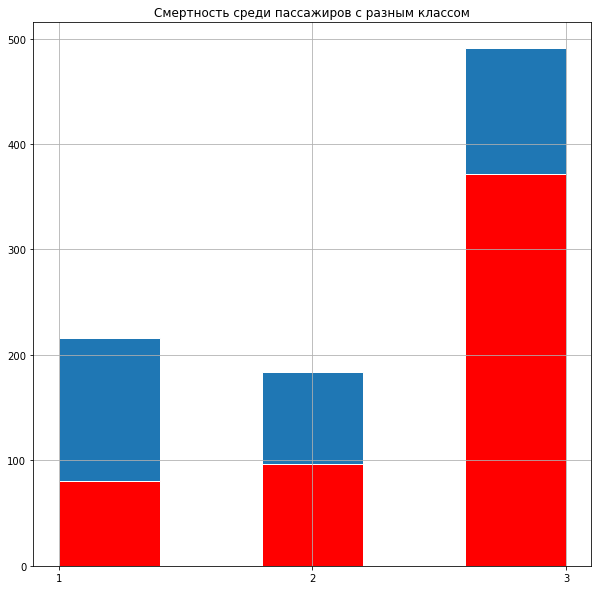

In [15]:
titanic_df.Pclass.hist(bins = 5, 
                       figsize = (10,10), 
                       edgecolor = 'white')
titanic_df.Pclass[titanic_df.Survived == 0].hist(bins = 5, 
                                                 figsize = (10,10),
                                                 edgecolor = 'white',
                                                 color = 'red')
plt.title('Смертность среди пассажиров с разным классом')
plt.xticks([1,2,3])
plt.show()

Со снижением значения класса снижается вероятность гибели. Для сравнения посмотрим на выживаемость в разрезе заплаченной за билет цены.

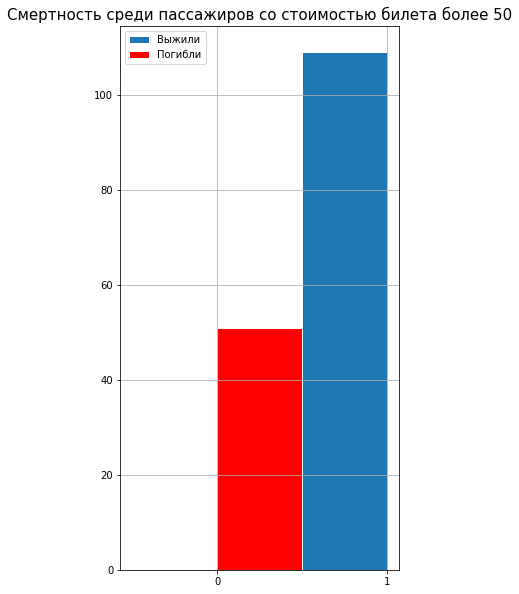

In [16]:
titanic_df.Survived[titanic_df.Fare > 50].hist(bins = 2, 
                                          figsize = (5,10), 
                                          edgecolor = 'white')
titanic_df.Survived[(titanic_df.Survived == 0) & (titanic_df.Fare > 50)].hist(bins = 2, 
                                                                         figsize = (5,10),
                                                                         edgecolor = 'white',
                                                                         color = 'red')
plt.title('Смертность среди пассажиров со стоимостью билета более 50', size = 15)
plt.legend(['Выжили', 'Погибли'])
plt.xticks([0,1])
plt.show()

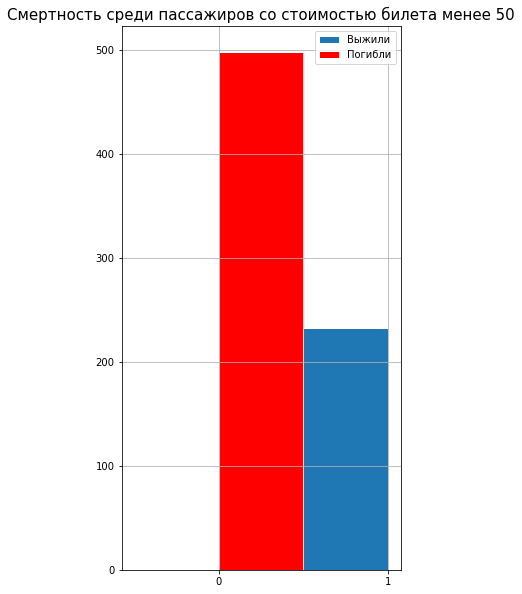

In [17]:
titanic_df.Survived[titanic_df.Fare <= 50].hist(bins = 2, 
                                           figsize = (5,10), 
                                           edgecolor = 'white')
titanic_df.Survived[(titanic_df.Survived == 0) & (titanic_df.Fare <= 50)].hist(bins = 2, 
                                                                          figsize = (5,10),
                                                                          edgecolor = 'white',
                                                                          color = 'red')
plt.title('Смертность среди пассажиров со стоимостью билета менее 50', size = 15)
plt.legend(['Выжили', 'Погибли'])
plt.xticks([0,1])
plt.show()

Очевидно, гипотеза подтверждена. Созависимость цены билета и выживания пассажира явно прослеживается.

### "Кто, если не я?!"
### Гипотеза №3 - мужчины жертвуют собой ради близких.

А если сформулировать точнее, то мужчины в возрасте старше 18 лет сначала будут стараться обеспечить безопасность своих близких, и только потом свою. В связи с чем у мужчин старше 18 (но младше 40) и наличием родственников выживаемость должна быть ниже. Посмотрим, правдива ли концовка фильма Титаник?

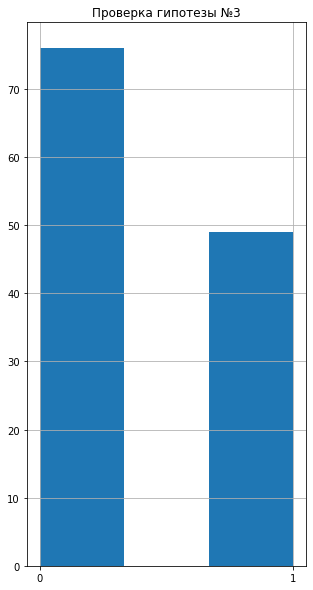

In [18]:
condition_Age = ((titanic_df.Age > 18) & (titanic_df.Age < 40))
condition_Sex = (titanic_df.Sex == 1)
condition_SibSP = (titanic_df.SibSp > 0)
condition_Parch = (titanic_df.Parch > 0)
men_with_SibSp = titanic_df.Survived[condition_Sex & condition_Age & condition_SibSP]
men_with_Parch = titanic_df.Survived[condition_Age & condition_Parch & condition_Parch]
hypothesis_3 = men_with_SibSp.append(men_with_Parch)
hypothesis_3.hist(figsize = (5,10), bins = 3)
plt.title('Проверка гипотезы №3')
plt.xticks([0,1])
plt.show()

В целом их выживаемость распределена равномерно относительно общей статистики. Моя третья гипотеза не нашла подтверждения. Посмотрю также отдельно по столбцам.

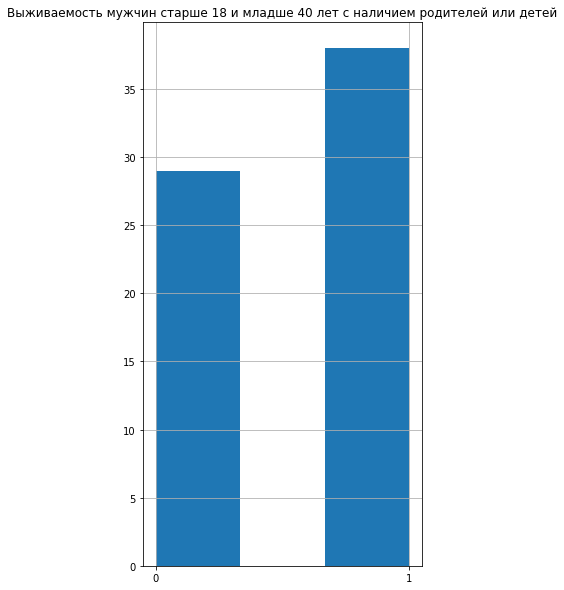

In [19]:
men_with_Parch.hist(figsize = (5,10), bins = 3)
plt.title('Выживаемость мужчин старше 18 и младше 40 лет с наличием родителей или детей')
plt.xticks([0,1])
plt.show()

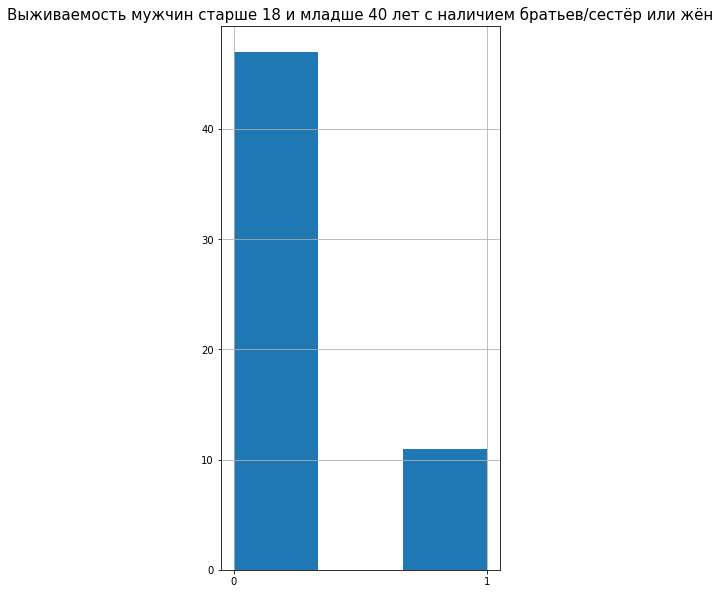

In [20]:
men_with_SibSp.hist(figsize = (5,10), bins = 3)
plt.title('Выживаемость мужчин старше 18 и младше 40 лет с наличием братьев/сестёр или жён', size = 15)
plt.xticks([0,1])
plt.show()

Интересно, что между ними такая значительная разница. На второй гистограмме, где рассматривается выборка мужчин между 18 и 40 годами с сёстрами и братьями/сёстрами или жёнами, смертность мужчин соответствует общей статистике по датасету. А вот на первой смертность меньше половины! Здесь у нас выборка мужчин в том же возрасте, но с наличием родителей/детей.

Напрашивается вывод о несостоятельности гипотезы. Однако, перед окончательным выводом я попробую исследовать эту выборку на предмет классов пассажиров.


In [21]:
titanic_df[condition_Sex & condition_Age & condition_SibSP].groupby(['Pclass', 'Survived'])['Name'].count()

Pclass  Survived
1       0            7
        1            7
2       0           19
        1            1
3       0           21
        1            3
Name: Name, dtype: int64

In [22]:
titanic_df[condition_Sex & condition_Age & condition_Parch].groupby(['Pclass','Survived'])['Name'].count()

Pclass  Survived
1       0           6
        1           4
2       0           8
3       0           5
        1           1
Name: Name, dtype: int64

Да, из этих таблиц видно, что статистику "смазывают" пассажиры, путешествующие первым классом. Их оказалось значительно больше в этой выборке, чем предполагает распределение по датасету. 

У пассажиров первого класса смертность в этих выборках составляет 50 и 60 процентнов соответственно. Что в целом ощутимо выше смертности пассажиров первого класса вообще.

Теперь протестируем нашу гипотезу снова, но удалим из выборки пассажиров первого класса.

### "Кто, если не я?!"
### Гипотеза №3.2 - мужчины жертвуют собой ради близких (но при билете первого класса это делать необязательно).

In [23]:
condition_Pclass = (titanic_df.Pclass > 1)
poor_men_with_Parch = titanic_df.Survived[condition_Pclass & condition_Age & condition_Sex & condition_Parch]
poor_men_with_SibSp = titanic_df.Survived[condition_Pclass & condition_Age & condition_Sex & condition_SibSP]

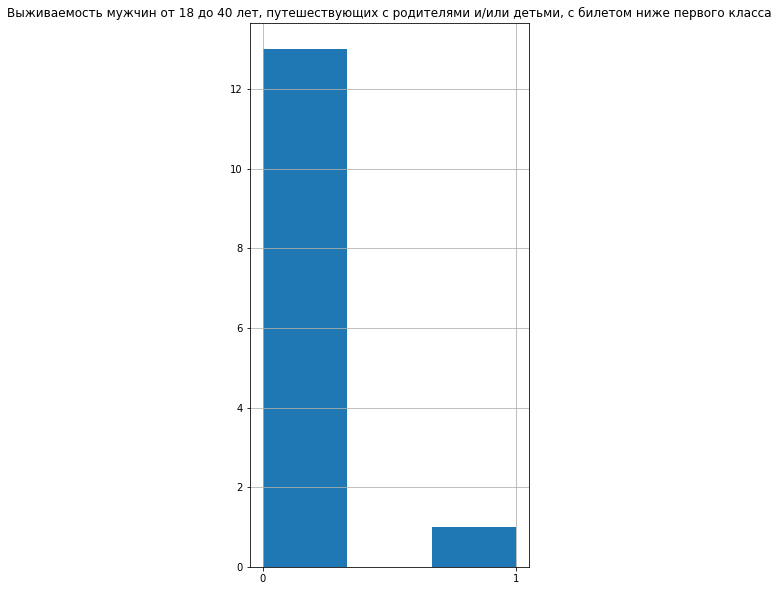

In [24]:
poor_men_with_Parch.hist(figsize = (5,10), bins = 3)
plt.title('Выживаемость мужчин от 18 до 40 лет, путешествующих с родителями и/или детьми, с билетом ниже первого класса')
plt.xticks([0,1])
plt.show()

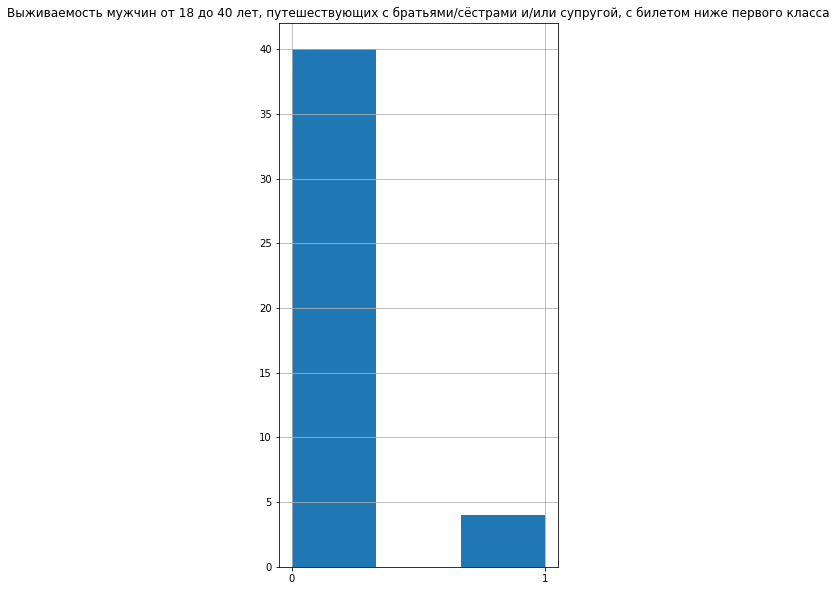

In [25]:
poor_men_with_SibSp.hist(figsize = (5,10), bins = 3)
plt.title('Выживаемость мужчин от 18 до 40 лет, путешествующих с братьями/сёстрами и/или супругой, с билетом ниже первого класса')
plt.xticks([0,1])
plt.show()

Пожалуй, верность третьей гипотезы с поправкой на первый класс можно подтвердить.

На этом я закончу исследование данных.